In [1]:
import os
import random
from PIL import Image
import numpy as np
import pandas as pd
from collections import Counter, defaultdict

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models

from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import matplotlib.pyplot as plt
import seaborn as sns

import cv2
import albumentations as A
from albumentations.pytorch import ToTensorV2

from tqdm import tqdm

torch.manual_seed(42)
np.random.seed(42)
random.seed(42)


In [11]:
import os
from PIL import Image
from torch.utils.data import Dataset

class TinyImageNetDataset(Dataset):
    def __init__(self, root_dir, split='train', transform=None):
        """
        root_dir: путь до папки tiny-imagenet-200
        split: 'train', 'val' или 'test'
        transform: трансформации изображений
        """
        self.root_dir = root_dir
        self.split = split
        self.transform = transform

        with open(os.path.join(root_dir, 'wnids.txt'), 'r') as f:
            self.class_names = [line.strip() for line in f]
        self.class_to_idx = {name: i for i, name in enumerate(self.class_names)}

        self.samples = []
        if split == 'train':
            train_dir = os.path.join(root_dir, 'train')
            for cls in os.listdir(train_dir):
                img_dir = os.path.join(train_dir, cls, 'images')
                if not os.path.exists(img_dir):
                    continue
                for img_name in os.listdir(img_dir):
                    img_path = os.path.join(img_dir, img_name)
                    label = self.class_to_idx[cls]
                    self.samples.append((img_path, label))

        elif split == 'val':
            val_dir = os.path.join(root_dir, 'val', 'images')
            anno_path = os.path.join(root_dir, 'val', 'val_annotations.txt')

            label_map = {}
            with open(anno_path, 'r') as f:
                for line in f:
                    img_name, cls, *_ = line.strip().split('\t')
                    label_map[img_name] = cls

            for img_name in os.listdir(val_dir):
                cls = label_map.get(img_name)
                if cls:
                    img_path = os.path.join(val_dir, img_name)
                    label = self.class_to_idx[cls]
                    self.samples.append((img_path, label))

        else:
            test_dir = os.path.join(root_dir, 'test', 'images')
            for img_name in os.listdir(test_dir):
                img_path = os.path.join(test_dir, img_name)
                self.samples.append((img_path, -1))  # тест без меток

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        img = Image.open(img_path).convert('RGB')
        if self.transform:
            img = self.transform(img)
        return img, label


train_transform = transforms.Compose([
    transforms.Resize((72, 72)),                    
    transforms.RandomResizedCrop(64, scale=(0.8, 1.0)),  
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),                     
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

val_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

root = "data/tiny-imagenet-200"

train_dataset = TinyImageNetDataset(root, split='train', transform=train_transform)
val_dataset = TinyImageNetDataset(root, split='val', transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)

print(f"Train size: {len(train_dataset)}")
print(f"Val size: {len(val_dataset)}")
print(f"Классов: {len(train_dataset.class_names)}")



Train size: 100000
Val size: 10000
Классов: 200


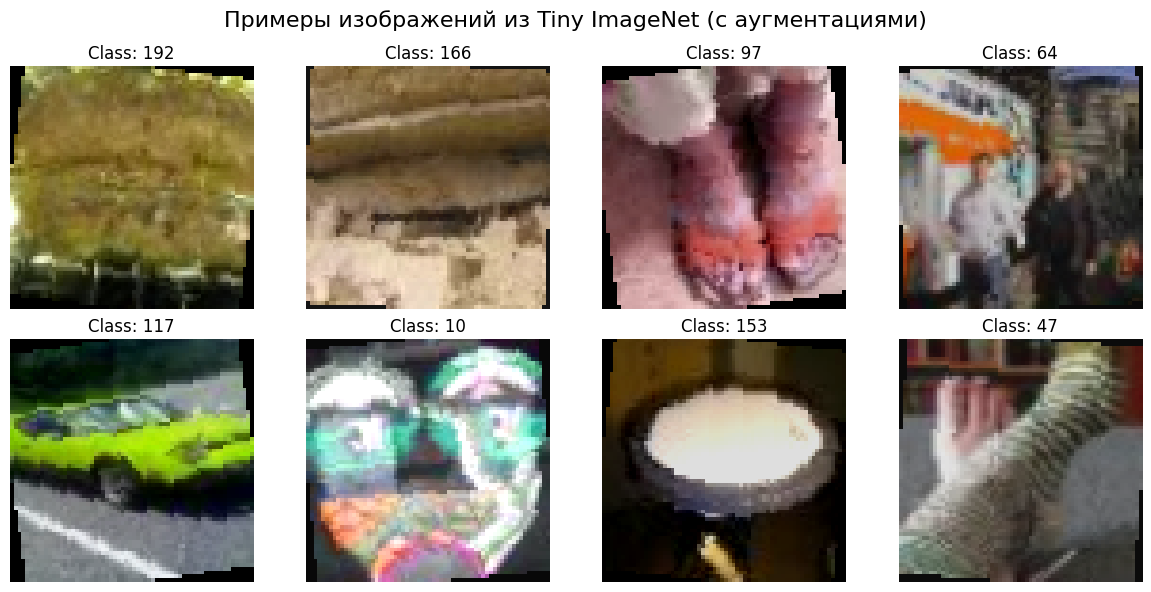

Размер батча: torch.Size([8, 3, 64, 64])
Диапазон значений: [-2.118, 2.640]
Метки классов: [192, 166, 97, 64, 117, 10, 153, 47]
Всего классов в датасете: 200
Примеры названий классов: ['n02124075', 'n04067472', 'n04540053', 'n04099969', 'n07749582']


In [12]:
images, labels = next(iter(train_loader))

def denormalize(img_tensor):
    """Вернём изображение из нормализованного диапазона в [0,1]"""
    mean = torch.tensor([0.485, 0.456, 0.406]).view(1, 1, 3)
    std = torch.tensor([0.229, 0.224, 0.225]).view(1, 1, 3)
    img = img_tensor.permute(1, 2, 0) * std + mean
    return img.clamp(0, 1)

images_vis = images.permute(0, 2, 3, 1)

images_vis = torch.stack([denormalize(img) for img in images])

plt.figure(figsize=(12, 6))
for i in range(8):
    plt.subplot(2, 4, i+1)
    plt.imshow(images_vis[i])
    plt.title(f"Class: {labels[i].item()}")
    plt.axis('off')
plt.suptitle("Примеры изображений из Tiny ImageNet (с аугментациями)", fontsize=16)
plt.tight_layout()
plt.show()

print(f"Размер батча: {images.shape}")
print(f"Диапазон значений: [{images.min():.3f}, {images.max():.3f}]")
print(f"Метки классов: {labels.tolist()}")
print(f"Всего классов в датасете: {len(train_dataset.class_names)}")
print(f"Примеры названий классов: {train_dataset.class_names[:5]}")



In [17]:
print(" Метод 1: Простая случайная стратификация")

train_dataset = TinyImageNetDataset(root, split='train', transform=train_transform)
all_samples = train_dataset.samples

print(f" Всего образцов: {len(all_samples)}")

def analyze_class_distribution(samples, name):
    labels = [label for _, label in samples]
    class_counts = Counter(labels)
    print(f" {name} - распределение классов:")
    print(f"   Минимум: {min(class_counts.values())}")
    print(f"   Максимум: {max(class_counts.values())}")
    print(f"   Среднее: {np.mean(list(class_counts.values())):.1f}")
    print(f"   Стандартное отклонение: {np.std(list(class_counts.values())):.1f}")

X = [x for x, y in all_samples]  # пути к изображениям
y = [y for x, y in all_samples]  # метки классов

print(f" Подготовлено {len(X)} образцов с {len(set(y))} классами")

sss = StratifiedShuffleSplit(n_splits=1, test_size=val_fraction, random_state=42)
train_idx, val_idx = next(sss.split(X, y))

# Создаем стратифицированные разделения
train_split_stratified = [all_samples[i] for i in train_idx]
val_split_stratified = [all_samples[i] for i in val_idx]

print(f" Стратифицированное разделение:")
print(f"   Train: {len(train_split_stratified)} образцов")
print(f"   Val: {len(val_split_stratified)} образцов")

# Анализируем распределение классов
analyze_class_distribution(train_split_stratified, "Стратифицированное train")
analyze_class_distribution(val_split_stratified, "Стратифицированное val")


 Метод 1: Простая случайная стратификация
 Всего образцов: 100000
 Подготовлено 100000 образцов с 200 классами
 Стратифицированное разделение:
   Train: 80000 образцов
   Val: 20000 образцов
 Стратифицированное train - распределение классов:
   Минимум: 400
   Максимум: 400
   Среднее: 400.0
   Стандартное отклонение: 0.0
 Стратифицированное val - распределение классов:
   Минимум: 100
   Максимум: 100
   Среднее: 100.0
   Стандартное отклонение: 0.0


In [18]:

selected_classes = [0, 5, 10, 15, 20]  # 5 классов
subset_samples = [s for s in train_dataset.samples if s[1] in selected_classes]

print(f"Используем {len(subset_samples)} изображений из {len(selected_classes)} классов")
print(f"Выбранные классы: {selected_classes}")

class CustomDataset(Dataset):
    def __init__(self, samples, transform=None):
        self.samples = samples
        self.transform = transform

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        img = Image.open(img_path).convert('RGB')
        if self.transform:
            img = self.transform(img)
        return img, label

train_subset_dataset = CustomDataset(subset_samples, transform=train_transform)
subset_loader = DataLoader(train_subset_dataset, batch_size=64, shuffle=False)

print(f"Создан датасет с {len(train_subset_dataset)} образцами")


Используем 2500 изображений из 5 классов
Выбранные классы: [0, 5, 10, 15, 20]
Создан датасет с 2500 образцами


In [23]:
# Заполните пропуски в BasicBlock
class BasicBlock(nn.Module):
    """
    Базовый блок ResNet с residual connection
    
    Args:
        in_channels (int): количество входных каналов
        out_channels (int): количество выходных каналов
        stride (int): шаг свертки (по умолчанию 1)
        downsample (nn.Module): слой для изменения размерности (если нужно)
    """
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super().__init__()

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.downsample = nn.Identity()
        if in_channels != out_channels:
            self.downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, padding=0),
                nn.BatchNorm2d(out_channels)
            )
            
        
    def forward(self, x):
        x_0 = x #то, что будет складываться
        x_0 = self.downsample(x)


        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.bn2(self.conv2(out))

        out += x_0 

        out = self.relu(out)
        
        return out

basic_block = BasicBlock(64, 128)
test_input = torch.randn(2, 64, 32, 32)

output = basic_block(test_input)
print(output.shape)

torch.Size([2, 128, 32, 32])


In [ ]:
class BottleneckBlock(nn.Module):
    """
    Bottleneck блок ResNet (1x1 -> 3x3 -> 1x1)
    Более эффективен для глубоких сетей
    
    Args:
        in_channels (int): количество входных каналов
        out_channels (int): количество выходных каналов
        stride (int): шаг свертки
        downsample (nn.Module): слой для изменения размерности
    """
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super().__init__()

    def forward(self, x):
        
        return None


bottleneck_block = BottleneckBlock(64, 256)
test_input = torch.randn(2, 64, 32, 32)

output = bottleneck_block(test_input)


### Архитектура ResNet


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class SimpleResNet18(nn.Module):
    def __init__(self, num_classes=200):
        super().__init__()

        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(2)

        self.basic_block_1_0 = BasicBlock(64, 64)
        self.basic_block_1_1 = BasicBlock(64, 64)

        self.basic_block_2_0 = BasicBlock(64, 128)
        self.basic_block_2_1 = BasicBlock(128, 128)

        self.basic_block_3_0 = BasicBlock(128, 256)
        self.basic_block_3_1 = BasicBlock(256, 256)

        self.basic_block_4_0 = BasicBlock(256, 512)
        self.basic_block_4_1 = BasicBlock(512, 512)

    def forward(self, x):

        return x


model = SimpleResNet18(num_classes=200)
test_input = torch.randn(1, 3, 224, 224)

output = model(test_input)

total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f" Всего параметров: {total_params:,}")
print(f" Обучаемых параметров: {trainable_params:,}")


